# Loading Data and Preprocessing

In [60]:
%%capture
%run "rfmvd.ipynb"

In [61]:
rfmvd_scaled = rfmvd_scaled # type: ignore
rfmvd_scaled_copy = rfmvd_scaled.copy()

In [62]:
rfmvd_scaled_copy.head(1)

,Recency,Frequency,Monetary,Variety,Duration
0,1.569937,-0.281706,-0.309073,-0.459605,0.073865


# Imports

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")

# Segmentation Algorithms

## K-means

There is a correlation between Frequency and Monetary. 
Uisng RFV then MD gives better results

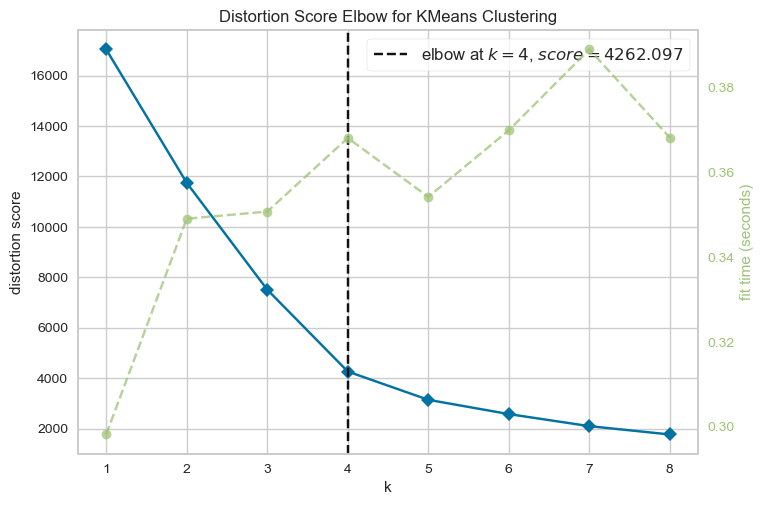

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [64]:
# RFM
vars = ['Recency', 'Frequency', 'Variety']
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,9))
visualizer.fit(rfmvd_scaled[vars]) 
visualizer.show()

In [65]:
n = 3
kmeans = KMeans(n_clusters=n, max_iter=500, random_state=1)
kmeans.fit(rfmvd_scaled[vars])

KMeans(max_iter=500, n_clusters=3, random_state=1)

In [66]:
rfmvd_scaled["Label1"] = kmeans.labels_

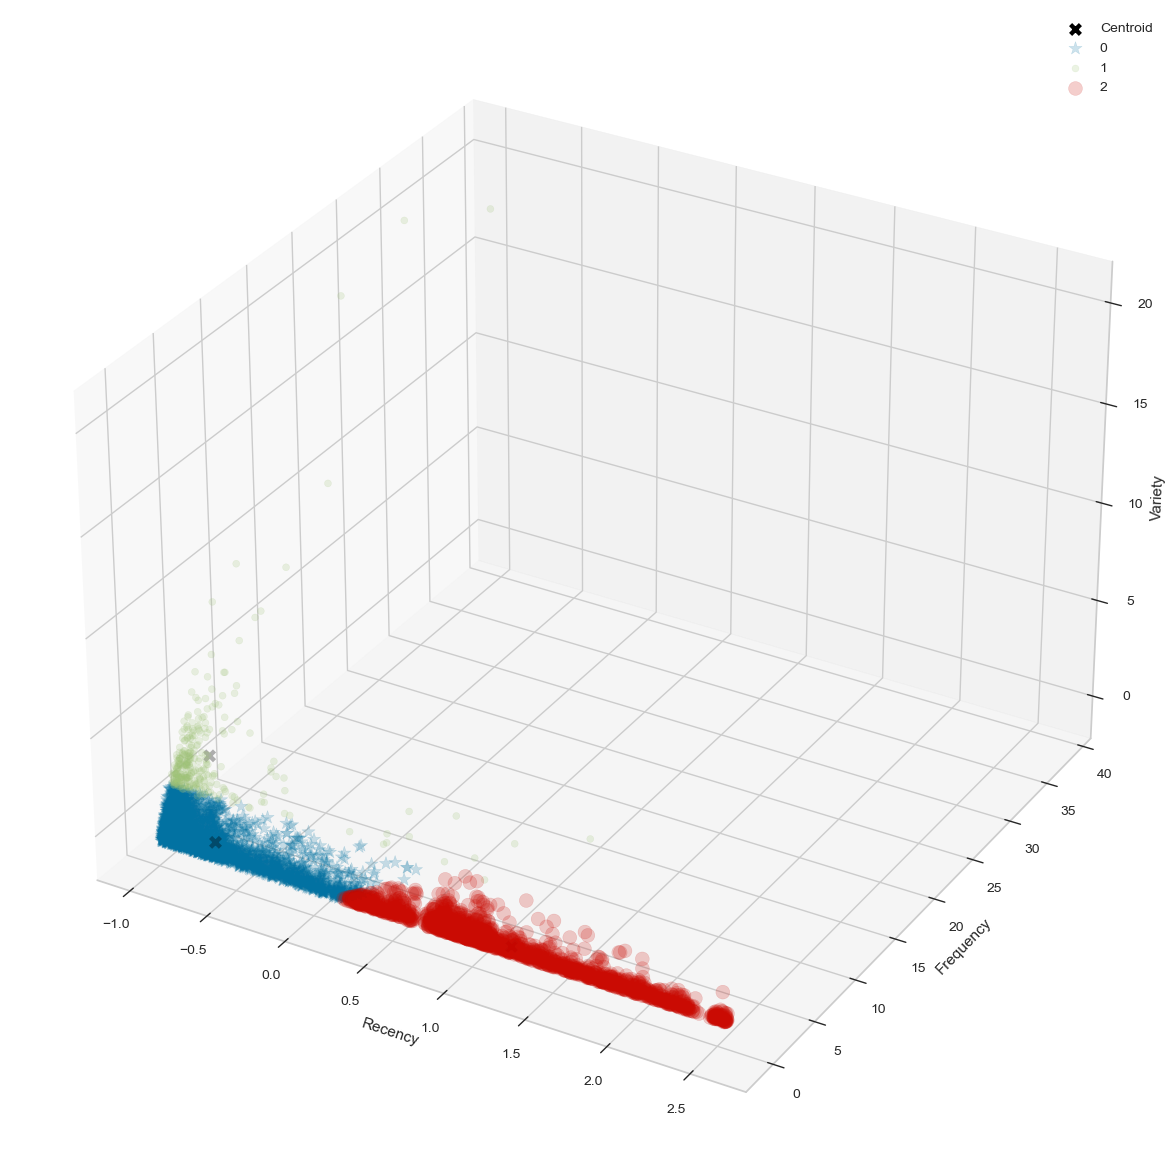

In [67]:
# RFM clustering graph
cluster_labels = kmeans.labels_
centroids = kmeans.cluster_centers_
u_labels = np.unique(cluster_labels)
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
# ax = plt.axes(projection='3d')
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Variety")
colors = []
markers = ['*', '.', 'o', '+']

# plotting centroids
ax.scatter(centroids[:,0] , centroids[:,1] , centroids[:,2], marker='x', 
                s=5, linewidths=10, c='black', label='Centroid', zorder=2)
#plotting the results:
for i in u_labels:
    ax.scatter(rfmvd_scaled[rfmvd_scaled.Label1 == i]['Recency'] , rfmvd_scaled[rfmvd_scaled.Label1 == i]['Frequency'] , rfmvd_scaled[rfmvd_scaled.Label1 == i]['Variety'], label = i, zorder=1, marker=markers[i], s=100, alpha=0.2)

ax.legend()
plt.show()

In [68]:
rfmvd_scaled.head(1)

,Recency,Frequency,Monetary,Variety,Duration,Label1
0,1.569937,-0.281706,-0.309073,-0.459605,0.073865,2


In [69]:
n2 = 3
for i in range(n):
    vd = rfmvd_scaled.loc[rfmvd_scaled.Label1 == i, ['Monetary', 'Duration']]
    kmeans = KMeans(n_clusters=n2, max_iter=500, random_state=1)
    kmeans.fit(vd)
    rfmvd_scaled.loc[rfmvd_scaled.Label1 == i, "Label2"] = kmeans.labels_

In [70]:
rfmvd_scaled.head(1)

,Recency,Frequency,Monetary,Variety,Duration,Label1,Label2
0,1.569937,-0.281706,-0.309073,-0.459605,0.073865,2,0.0


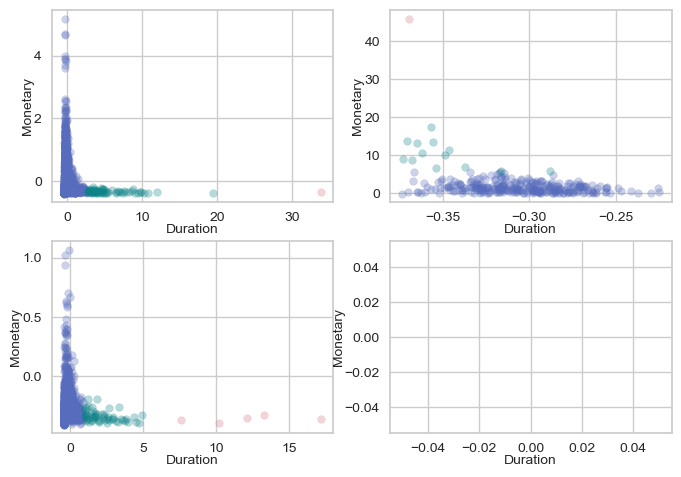

In [71]:
# DFM clustering graph
colors = ['#576CBC', '#D27685', '#0E8388']
markers = ['*', '.', '+']
fig, axs = plt.subplots(2, 2)
m = 0
for i in range(2):
    for l in range(2):
        for k in range(3):
            axs[i, l].scatter(rfmvd_scaled[(rfmvd_scaled.Label1 == m) & (rfmvd_scaled.Label2 == k)]['Duration'] , rfmvd_scaled[(rfmvd_scaled.Label1 == m) & (rfmvd_scaled.Label2 == k)]['Monetary'], label = k, s=30, c=colors[k], alpha=0.3)
            axs[i, l].set_xlabel("Duration", labelpad=0, fontsize=10)
            axs[i, l].set_ylabel("Monetary", labelpad=0, fontsize=10)
        m += 1
# axs.legend()
plt.show()

# Comparing DCS To Direct RFVMD Segmentation 

In [72]:
n = 9
vars = ["Recency", "Frequency",	"Monetary", "Variety", "Duration"]
kmeans = KMeans(n_clusters=n, max_iter=500, random_state=1)
kmeans.fit(rfmvd_scaled_copy[vars])

KMeans(max_iter=500, n_clusters=9, random_state=1)

In [73]:
rfmvd_scaled_copy["Label"] = kmeans.labels_

In [74]:
rfmvd_scaled_copy.head(1)

,Recency,Frequency,Monetary,Variety,Duration,Label
0,1.569937,-0.281706,-0.309073,-0.459605,0.073865,1


In [75]:
cluster_labels = kmeans.labels_
print(f"For n = {n}:")
kmeans_s = silhouette_score(rfmvd_scaled_copy, cluster_labels)
print(f"> Silhouette score: {kmeans_s}")

For n = 9:
> Silhouette score: 0.6909895163953897


## DCS Score

In [76]:
rfmvd_scaled.head(1)
rfmvd = rfmvd_scaled[["Recency", "Frequency", "Monetary", "Variety", "Duration"]]

In [77]:
rfmvd.head(1)

,Recency,Frequency,Monetary,Variety,Duration
0,1.569937,-0.281706,-0.309073,-0.459605,0.073865


In [78]:
# Concatentate Label1 and Label2 into Label
rfmvd["Label"] = (rfmvd_scaled.Label1.astype(str) + rfmvd_scaled.Label2.astype(int).astype(str)).astype(int)

In [83]:
# Matching each label to a values between 0 and 8
for i in range(len(u_labels)):
    rfmvd.loc[rfmvd.Label == u_labels[i],["Label"]] = i 

In [84]:
u_labels = np.unique(rfmvd["Label"])
print(u_labels)

[0 1 2 3 4 5 6 7 8]


In [85]:
rfmvd.head(1)

,Recency,Frequency,Monetary,Variety,Duration,Label
0,1.569937,-0.281706,-0.309073,-0.459605,0.073865,6


In [86]:
cluster_labels = rfmvd["Label"] 
kmeans_s = silhouette_score(rfmvd, cluster_labels)
print(f"> Silhouette score: {kmeans_s}")

> Silhouette score: 0.7240582041018517
